In [ ]:
import os
from flask import Flask, jsonify
import pandas as pd
from sklearn.preprocessing import StandardScaler
from pyspark.sql.functions import countDistinct
from pyspark.sql import SparkSession
from pyspark import SparkFiles
import requests

# Create a Spark session
spark = SparkSession.builder.appName("Cardio Disease Risk").getOrCreate()

In [ ]:
from pyspark import SparkFiles

url = "https://raw.githubusercontent.com/vokouns/Cardiovascular-Diseases-Risk-Prediction/refs/heads/main/data/CVD_cleaned.csv"
spark.sparkContext.addFile(url)
df = spark.read.csv(SparkFiles.get("CVD_cleaned.csv"), sep=",", header=True)
df.show()

+--------------+--------------------+--------+-------------+-----------+------------+----------+--------+---------+------+------------+-----------+-----------+-----+---------------+-------------------+-----------------+----------------------------+-----------------------+
|General_Health|             Checkup|Exercise|Heart_Disease|Skin_Cancer|Other_Cancer|Depression|Diabetes|Arthritis|   Sex|Age_Category|Height_(cm)|Weight_(kg)|  BMI|Smoking_History|Alcohol_Consumption|Fruit_Consumption|Green_Vegetables_Consumption|FriedPotato_Consumption|
+--------------+--------------------+--------+-------------+-----------+------------+----------+--------+---------+------+------------+-----------+-----------+-----+---------------+-------------------+-----------------+----------------------------+-----------------------+
|          Poor|Within the past 2...|      No|           No|         No|          No|        No|      No|      Yes|Female|       70-74|      150.0|      32.66|14.54|            Yes|

In [ ]:
# Drop the 'Checkup' column
df = df.drop('Checkup')

# Display the first few rows of the modified DataFrame
df.show()


+--------------+--------+-------------+-----------+------------+----------+--------+---------+------+------------+-----------+-----------+-----+---------------+-------------------+-----------------+----------------------------+-----------------------+
|General_Health|Exercise|Heart_Disease|Skin_Cancer|Other_Cancer|Depression|Diabetes|Arthritis|   Sex|Age_Category|Height_(cm)|Weight_(kg)|  BMI|Smoking_History|Alcohol_Consumption|Fruit_Consumption|Green_Vegetables_Consumption|FriedPotato_Consumption|
+--------------+--------+-------------+-----------+------------+----------+--------+---------+------+------------+-----------+-----------+-----+---------------+-------------------+-----------------+----------------------------+-----------------------+
|          Poor|      No|           No|         No|          No|        No|      No|      Yes|Female|       70-74|      150.0|      32.66|14.54|            Yes|                0.0|             30.0|                        16.0|                 

In [ ]:
# Check the DataFrame data types
df.dtypes

# Convert Spark DataFrame to Pandas DataFrame
heart_df = df.toPandas()

# Display the Pandas DataFrame
heart_df.head()

,General_Health,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,Poor,No,No,No,No,No,No,Yes,Female,70-74,150.0,32.66,14.54,Yes,0.0,30.0,16.0,12.0
1,Very Good,No,Yes,No,No,No,Yes,No,Female,70-74,165.0,77.11,28.29,No,0.0,30.0,0.0,4.0
2,Very Good,Yes,No,No,No,No,Yes,No,Female,60-64,163.0,88.45,33.47,No,4.0,12.0,3.0,16.0
3,Poor,Yes,Yes,No,No,No,Yes,No,Male,75-79,180.0,93.44,28.73,No,0.0,30.0,30.0,8.0
4,Good,No,No,No,No,No,No,No,Male,80+,191.0,88.45,24.37,Yes,0.0,8.0,4.0,0.0


In [ ]:
# Scaling the numeric columns
health_data_scaled = StandardScaler().fit_transform(heart_df[["Height_(cm)", "Weight_(kg)", "BMI", "Alcohol_Consumption", "Fruit_Consumption", "Green_Vegetables_Consumption", "FriedPotato_Consumption"]])

# Creating a DataFrame with the scaled data
health_transformed_df = pd.DataFrame(health_data_scaled, columns=["Height_(cm)", "Weight_(kg)", "BMI", "Alcohol_Consumption", "Fruit_Consumption", "Green_Vegetables_Consumption", "FriedPotato_Consumption"])

# Display data
health_transformed_df .head()

,Height_(cm),Weight_(kg),BMI,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,-1.934250,-2.386180,-2.159696,-0.621527,0.006625,0.059597,0.664502
1,-0.526857,-0.303547,-0.051548,-0.621527,0.006625,-1.012342,-0.267579
2,-0.714510,0.227770,0.742649,-0.133707,-0.716973,-0.811354,1.130543
3,0.880535,0.461569,0.015913,-0.621527,0.006625,0.997544,0.198462
4,1.912623,0.227770,-0.652562,-0.621527,-0.877772,-0.744358,-0.733620


In [ ]:
# Transform the Categorical data column using get_dummies()
health_dummies_df = pd.get_dummies(heart_df[["General_Health", "Exercise", "Heart_Disease", "Skin_Cancer", "Other_Cancer", "Depression", "Diabetes", "Arthritis", "Sex", "Age_Category", "Smoking_History"]], dtype=int)

# Display sample data
health_dummies_df.head()

,General_Health_Excellent,General_Health_Fair,General_Health_Good,General_Health_Poor,General_Health_Very Good,Exercise_No,Exercise_Yes,Heart_Disease_No,Heart_Disease_Yes,Skin_Cancer_No,...,Age_Category_45-49,Age_Category_50-54,Age_Category_55-59,Age_Category_60-64,Age_Category_65-69,Age_Category_70-74,Age_Category_75-79,Age_Category_80+,Smoking_History_No,Smoking_History_Yes
0,0,0,0,1,0,1,0,1,0,1,...,0,0,0,0,0,1,0,0,0,1
1,0,0,0,0,1,1,0,0,1,1,...,0,0,0,0,0,1,0,0,1,0
2,0,0,0,0,1,0,1,1,0,1,...,0,0,0,1,0,0,0,0,1,0
3,0,0,0,1,0,0,1,0,1,1,...,0,0,0,0,0,0,1,0,1,0
4,0,0,1,0,0,1,0,1,0,1,...,0,0,0,0,0,0,0,1,0,1


In [ ]:
# Concatenate the scaled and the dummies DataFrames
df_transformed = pd.concat([health_transformed_df, health_dummies_df], axis=1)

# Display sample data
df_transformed.head()

,Height_(cm),Weight_(kg),BMI,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption,General_Health_Excellent,General_Health_Fair,General_Health_Good,...,Age_Category_45-49,Age_Category_50-54,Age_Category_55-59,Age_Category_60-64,Age_Category_65-69,Age_Category_70-74,Age_Category_75-79,Age_Category_80+,Smoking_History_No,Smoking_History_Yes
0,-1.934250,-2.386180,-2.159696,-0.621527,0.006625,0.059597,0.664502,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,-0.526857,-0.303547,-0.051548,-0.621527,0.006625,-1.012342,-0.267579,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,-0.714510,0.227770,0.742649,-0.133707,-0.716973,-0.811354,1.130543,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,0.880535,0.461569,0.015913,-0.621527,0.006625,0.997544,0.198462,0,0,0,...,0,0,0,0,0,0,1,0,1,0
4,1.912623,0.227770,-0.652562,-0.621527,-0.877772,-0.744358,-0.733620,0,0,1,...,0,0,0,0,0,0,0,1,0,1


In [ ]:
# Save the column structure
df_transformed_columns = df_transformed.columns.tolist()
print(df_transformed_columns)

['Height_(cm)', 'Weight_(kg)', 'BMI', 'Alcohol_Consumption', 'Fruit_Consumption', 'Green_Vegetables_Consumption', 'FriedPotato_Consumption', 'General_Health_Excellent', 'General_Health_Fair', 'General_Health_Good', 'General_Health_Poor', 'General_Health_Very Good', 'Exercise_No', 'Exercise_Yes', 'Heart_Disease_No', 'Heart_Disease_Yes', 'Skin_Cancer_No', 'Skin_Cancer_Yes', 'Other_Cancer_No', 'Other_Cancer_Yes', 'Depression_No', 'Depression_Yes', 'Diabetes_No', 'Diabetes_No, pre-diabetes or borderline diabetes', 'Diabetes_Yes', 'Diabetes_Yes, but female told only during pregnancy', 'Arthritis_No', 'Arthritis_Yes', 'Sex_Female', 'Sex_Male', 'Age_Category_18-24', 'Age_Category_25-29', 'Age_Category_30-34', 'Age_Category_35-39', 'Age_Category_40-44', 'Age_Category_45-49', 'Age_Category_50-54', 'Age_Category_55-59', 'Age_Category_60-64', 'Age_Category_65-69', 'Age_Category_70-74', 'Age_Category_75-79', 'Age_Category_80+', 'Smoking_History_No', 'Smoking_History_Yes']


In [ ]:
import joblib
joblib.dump(df_transformed_columns, "column_list.pkl")

['column_list.pkl']

In [ ]:
# Determine the number of unique values in each column.
for column in df_transformed.columns:
    # Use nunique() method from pandas to get the number of unique values
    num_unique = df_transformed[column].nunique()
    print(f"Column '{column}' has {num_unique} unique values.")

Column 'Height_(cm)' has 99 unique values.
Column 'Weight_(kg)' has 525 unique values.
Column 'BMI' has 3654 unique values.
Column 'Alcohol_Consumption' has 31 unique values.
Column 'Fruit_Consumption' has 77 unique values.
Column 'Green_Vegetables_Consumption' has 75 unique values.
Column 'FriedPotato_Consumption' has 69 unique values.
Column 'General_Health_Excellent' has 2 unique values.
Column 'General_Health_Fair' has 2 unique values.
Column 'General_Health_Good' has 2 unique values.
Column 'General_Health_Poor' has 2 unique values.
Column 'General_Health_Very Good' has 2 unique values.
Column 'Exercise_No' has 2 unique values.
Column 'Exercise_Yes' has 2 unique values.
Column 'Heart_Disease_No' has 2 unique values.
Column 'Heart_Disease_Yes' has 2 unique values.
Column 'Skin_Cancer_No' has 2 unique values.
Column 'Skin_Cancer_Yes' has 2 unique values.
Column 'Other_Cancer_No' has 2 unique values.
Column 'Other_Cancer_Yes' has 2 unique values.
Column 'Depression_No' has 2 unique v

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


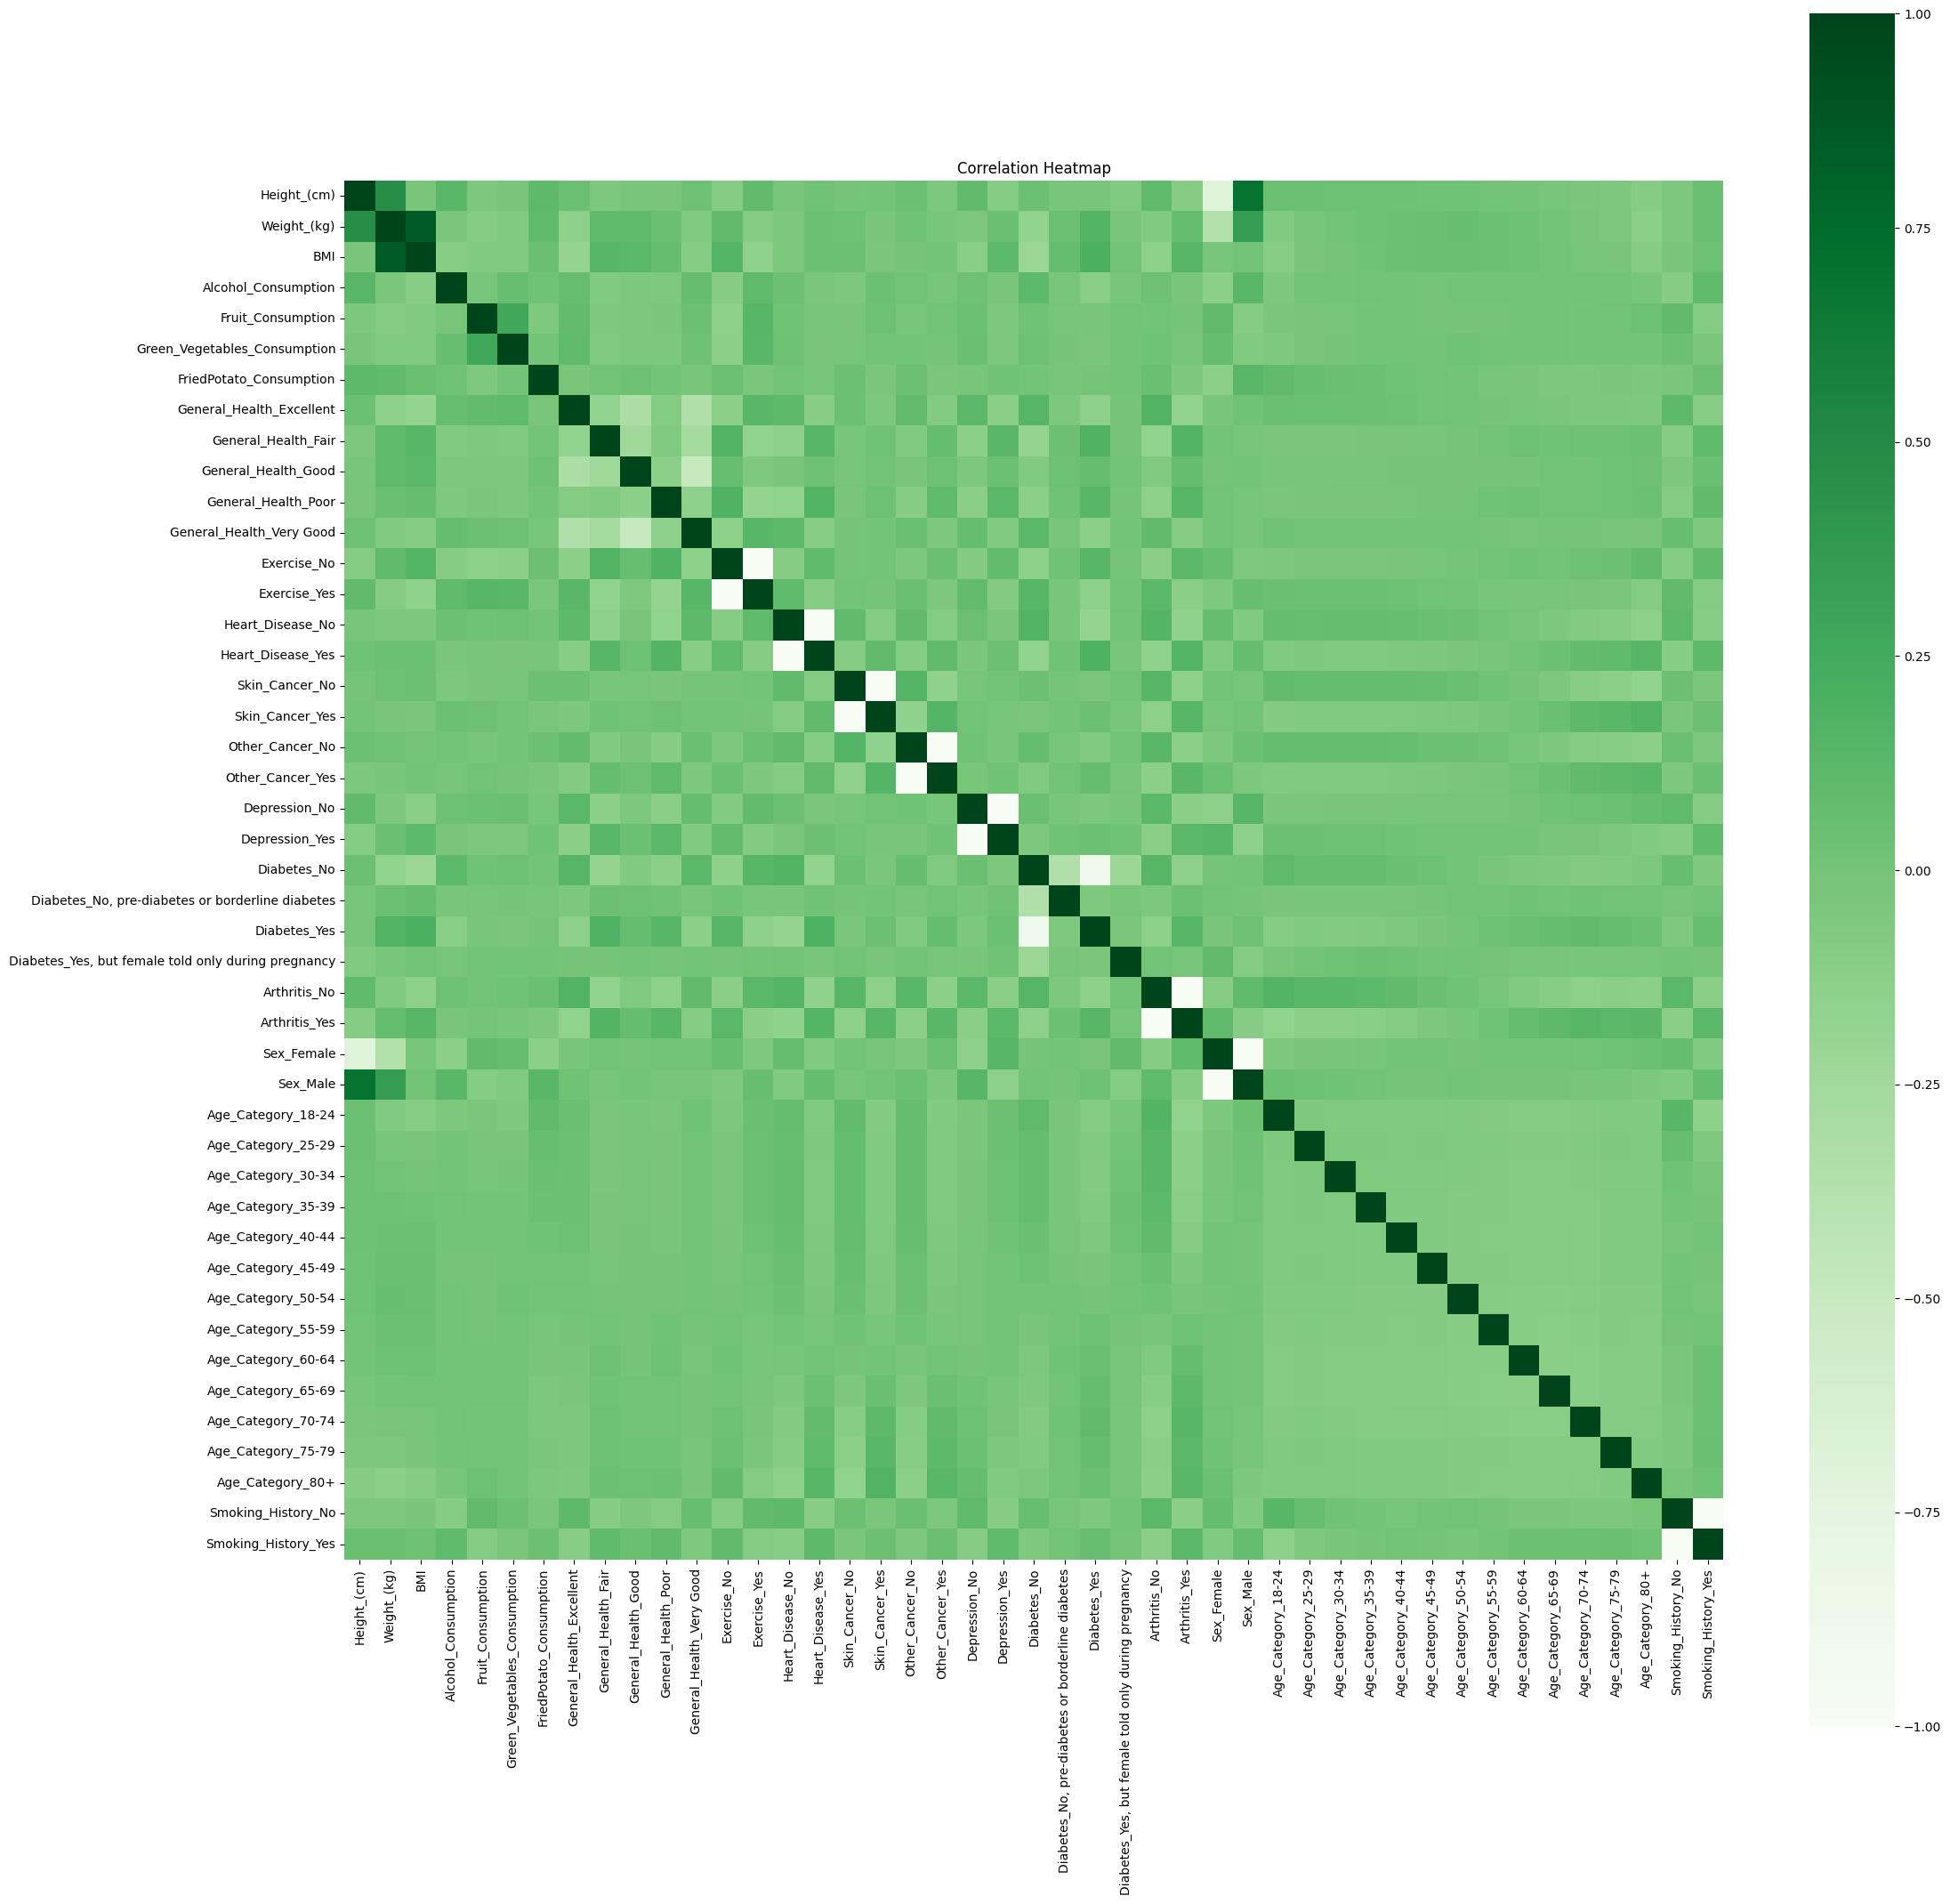

In [ ]:
# Create a Heatmap to visualize the correlation among the different features of our dataset
correlation_matrix = df_transformed.corr()

# Create a heatmap
plt.figure(figsize=(25,25))
sns.heatmap(df_transformed.corr(), cbar=True, square=True, cmap="Greens", annot=False)
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf

In [ ]:
# Split our preprocessed data into our features and target arrays
# X should include all features EXCEPT the target variables
# y should be the target variable
X = df_transformed.drop(["Heart_Disease_Yes","Heart_Disease_No"],axis=1).values
y = df_transformed["Heart_Disease_Yes"].values

# Split the data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=72)

In [ ]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [ ]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
input_features = len(X_train[0])
hidden_nodes_layer1 = 72
hidden_nodes_layer2 = 34
hidden_nodes_layer3 = 8

nn_model = tf.keras.models.Sequential()

# First hidden layer
nn_model.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, activation="relu", input_dim=input_features))

# Second hidden layer
nn_model.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Third hidden layer
nn_model.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="relu"))

# Output layer
nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 72)                  │           3,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 34)                  │           2,482 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │             280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,939 (23.20 KB)

 Trainable params: 5,939 (23.20 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile the model
nn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
# Train the model
fit_model = nn_model.fit(X_train_scaled, y_train, epochs=50)

Epoch 1/50
7239/7239 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9123 - loss: 0.2382
Epoch 2/50
7239/7239 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9197 - loss: 0.2218
Epoch 3/50
7239/7239 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.9197 - loss: 0.2217
Epoch 4/50
7239/7239 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.9197 - loss: 0.2200
Epoch 5/50
7239/7239 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.9196 - loss: 0.2206
Epoch 6/50
7239/7239 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - accuracy: 0.9202 - loss: 0.2201
Epoch 7/50
7239/7239 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.9193 - loss: 0.2204
Epoch 8/50
7239/7239 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9195 - loss: 0.2209
Epoch 9/50
7239/7239 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9199 - loss: 0.2201
Epoch 10/50
7239/7239 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9194 - loss: 0.2195
Epoch 11/50
7239/7239 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9203 - loss: 0.2179
Epoch 12/50
7239/72

In [ ]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn_model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

2413/2413 - 3s - 1ms/step - accuracy: 0.9173 - loss: 0.2313
Loss: 0.23130692541599274, Accuracy: 0.9173206686973572


In [ ]:
# Calculating the confusion matrix
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Making predictions using the testing data
predictions = nn_model.predict(X_test_scaled)

# Convert predictions to binary class labels using a threshold (e.g., 0.8)
predictions = (predictions > 0.8).astype(int)

# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)


2413/2413 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


In [ ]:
# Displaying results
print("Confusion Matrix")
display(cm_df)

print("Classification Report")
print(classification_report(y_test, predictions,
                            target_names=["No Heart Disease", "Heart Disease"]))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,70912,62
Actual 1,6190,50


Classification Report
                  precision    recall  f1-score   support

No Heart Disease       0.92      1.00      0.96     70974
   Heart Disease       0.45      0.01      0.02      6240

        accuracy                           0.92     77214
       macro avg       0.68      0.50      0.49     77214
    weighted avg       0.88      0.92      0.88     77214



In [ ]:
# Alternative model - Random Forest
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Copy original dataframe
random_df = df_transformed.copy()

# Define features set
X = random_df.drop(["Heart_Disease_Yes","Heart_Disease_No"],axis=1)

# Define target vector
y = random_df["Heart_Disease_Yes"].values.reshape(-1, 1)

# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=72)

# Create the StandardScaler instance
scaler = StandardScaler()

# Fit the Standard Scaler with the training data
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=72)

# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [ ]:
# Displaying results
print("Confusion Matrix")
display(cm_df)

print(f"Accuracy Score : {acc_score}")

print("Classification Report")
print(classification_report(y_test, predictions,
                            target_names=["No Heart Disease", "Heart Disease"]))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,70552,422
Actual 1,5946,294


Accuracy Score : 0.9175279094464734
Classification Report
                  precision    recall  f1-score   support

No Heart Disease       0.92      0.99      0.96     70974
   Heart Disease       0.41      0.05      0.08      6240

        accuracy                           0.92     77214
       macro avg       0.67      0.52      0.52     77214
    weighted avg       0.88      0.92      0.89     77214



In [ ]:
# Save the Keras model as an .h5 file
nn_model.save('nn_model.keras')

In [ ]:
import joblib

# Save the scaler to a file
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']